In [1]:
pip install tensorflow==2.9.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2 as cv2
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
import shutil
import cv2 as cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
IMAGE_SIZE = [224, 224]

In [4]:

rn = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",input_shape=IMAGE_SIZE + [3], pooling='max')

In [5]:
#for layer in rn.layers:
 #   layer.trainable = True

In [6]:
x =Flatten()(rn.output)
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x) 

In [7]:
prediction = Dense(28, activation='softmax')(x)
model = Model(inputs=rn.input, outputs=prediction)

In [8]:
sdir=r'/kaggle/input/arsl-sign-language/data_for_all'
classlist= os.listdir(sdir)
filepaths=[]
labels=[]    
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    flist=os.listdir(classpath) 
    for f in flist:
        fpath=os.path.join(classpath,f)            
        filepaths.append(fpath) 
        labels.append(klass)            
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
trsplit=.9
vsplit=.05
dsplit=vsplit/(1-trsplit)
strat=df['labels']
train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
strat=dummy_df['labels']
valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
balance=list(train_df['labels'].value_counts())
print (balance)

train_df length:  11540   test_df length:  642   valid_df length:  641
[536, 482, 475, 473, 457, 450, 446, 446, 446, 443, 443, 437, 434, 431, 429, 429, 428, 414, 411, 409, 404, 392, 389, 388, 373, 279, 208, 188]


In [9]:

train_datagen = ImageDataGenerator(rescale = 1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1)
val_datagen = ImageDataGenerator(rescale = 1)

training_set = train_datagen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True)

test_set = test_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False)
val_set = val_datagen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True)


Found 11540 validated image filenames belonging to 28 classes.
Found 642 validated image filenames belonging to 28 classes.
Found 641 validated image filenames belonging to 28 classes.


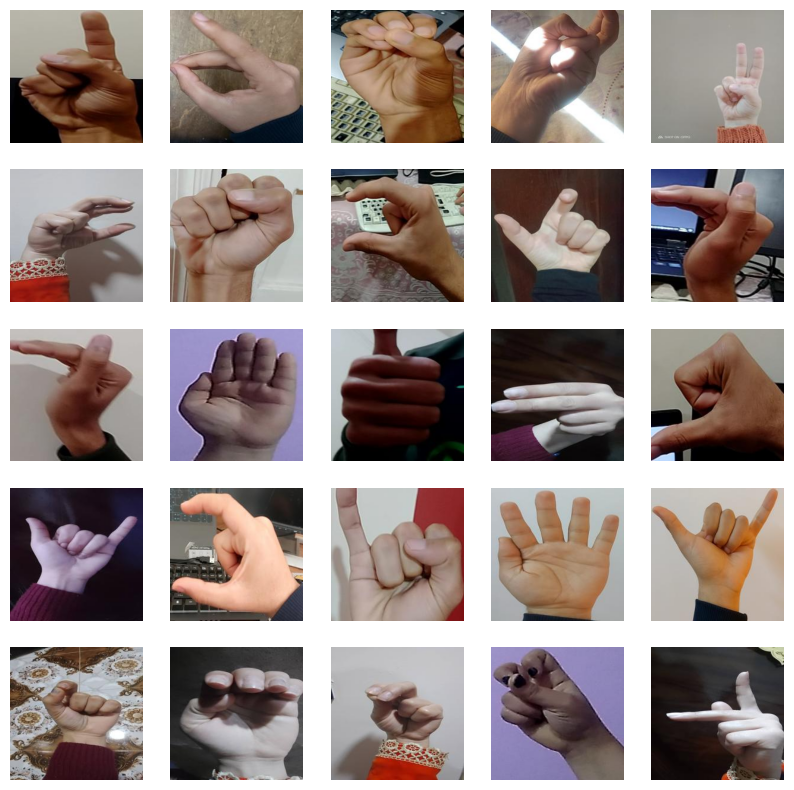

In [10]:
plt.figure(figsize=(10, 10))
x,y = training_set .next()
for i in range(0,25):
    ax = plt.subplot(5, 5, i + 1)
    image = x[i]
    plt.imshow(image.astype('uint8'))
    plt.axis("off")

In [11]:
import keras
import tensorflow as tf
opt = tf.keras.optimizers.Adamax(lr=.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["accuracy"]
)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [12]:
import time 
print(time.ctime())
from time import time
t_start = time()

Wed May 17 21:38:36 2023


In [13]:
import keras
import tensorflow as tf
from keras.callbacks import  ReduceLROnPlateau,ModelCheckpoint
annealer=ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,verbose=1, lr=0.001)
checkpoint = ModelCheckpoint('arsl.h5', verbose=1, save_best_only=True, mode='min', save_freq='epoch',monitor='val_loss')


In [14]:
history = model.fit(
                  training_set,
                  validation_data=val_set,
                  epochs=14,
                  batch_size=32,
                  callbacks=[annealer,checkpoint],
                  steps_per_epoch=len(training_set),
                  validation_steps=len(test_set)
                )

Epoch 1/14
361/361 [==============================] - ETA: 0s - loss: 6.1141 - accuracy: 0.8340
Epoch 1: val_loss improved from inf to 3.68046, saving model to arsl.h5
361/361 [==============================] - 133s 331ms/step - loss: 6.1141 - accuracy: 0.8340 - val_loss: 3.6805 - val_accuracy: 0.9828 - lr: 0.0010
Epoch 2/14
361/361 [==============================] - ETA: 0s - loss: 2.5157 - accuracy: 0.9853
Epoch 2: val_loss improved from 3.68046 to 1.52173, saving model to arsl.h5
361/361 [==============================] - 117s 324ms/step - loss: 2.5157 - accuracy: 0.9853 - val_loss: 1.5217 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 3/14
361/361 [==============================] - ETA: 0s - loss: 1.0799 - accuracy: 0.9938
Epoch 3: val_loss improved from 1.52173 to 0.68936, saving model to arsl.h5
361/361 [==============================] - 117s 325ms/step - loss: 1.0799 - accuracy: 0.9938 - val_loss: 0.6894 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 4/14
361/361 [========================

In [15]:
#time.ctime()
train_time = time() - t_start
print('\nTrain time: %.3f'%(train_time/60), ' mins')


Train time: 27.611  mins


In [16]:
model.save("arsl.h5")

import json
np.save('my_history.npy',history.history)
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [17]:
from time import time
start = time()
evl = model.evaluate(test_set)
test_time = time() - start

test_loss, test_acc = evl[0]*100, evl[1]*100

msg = f'Test Accuracy = {test_acc:5.2f} %'
msg1 = f'Test Loss = {test_loss:5.2f} %'
msg2 = f'Test Time = {test_time:5.2f} s'
print(msg)
print(msg1)
print(msg2)

21/21 [==============================] - 4s 211ms/step - loss: 0.1943 - accuracy: 0.9938
Test Accuracy = 99.38 %
Test Loss = 19.43 %
Test Time =  4.65 s


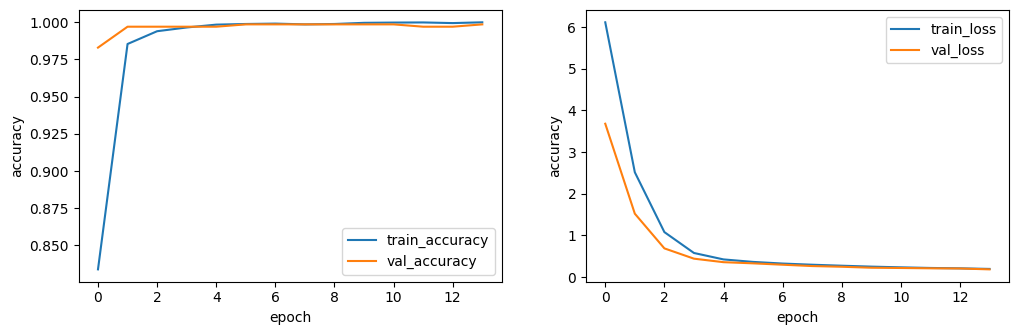

In [18]:
# Plotting Loss & Accuracy Graphs
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [19]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

True :  [15  8 23  8 26  1  1 25  9 12 18 21 12 21  5 21  0 18 16 10  9 13  6  5
 16  2  4  8 14 25 22 25 14 10 20  8 25 16  2 25  9  2 21  9 25 20 23 27
 26  2 19 12 22 22 15 19 14 26  3 10 17 15  7 25 10  4 10 13  5 26 21 20
 15 17 26 22 18  7 10 16 21  9 10 26 22 13 10  9 15 21 26 19 23 22 20 19
  6 13  2 13 21 18 17 18 15 26  2 24 12 24 20  1  9  1 12  4 22  4  5  6
 14 15  3 23 15  8 22 21 19  2 23  7 24 22 14 15 25 19 24 12  7 12  0  1
 15  7 16 16 10  5  9  6  4  5 26 14 17 23  9 16 17 21 17  3 10 11 22 12
 14 21  9 21 14 13 17 19 11 17 14 12 13 16  9  1 24 10 20 12 18  3 22 20
 23 18 23  7 23 27 26  1  6 18 13 22 15 12 10 25  2 12 12  1  2  6  4 25
  7 18 26  3  0  6 24 19 11 14  4  4 19 24  3 21  4  9 22 20 15  7 11  2
 24  5 19  1  9  2  2  6 10 14 17 17  1  2 25  0 20 10  0 26  1  5  3  4
  5 20  1  0  8  0 14 21 27 27 21 22 23 10  6 10  2  8 17  8 27 25 25 27
  1  9 16 15 10 12  8  5 12 21 20  6 12 23  7 18  5 14 23  6 20  9  1  5
 24 22 18  1 16  6 12 13 20  1 27  2  0  2 

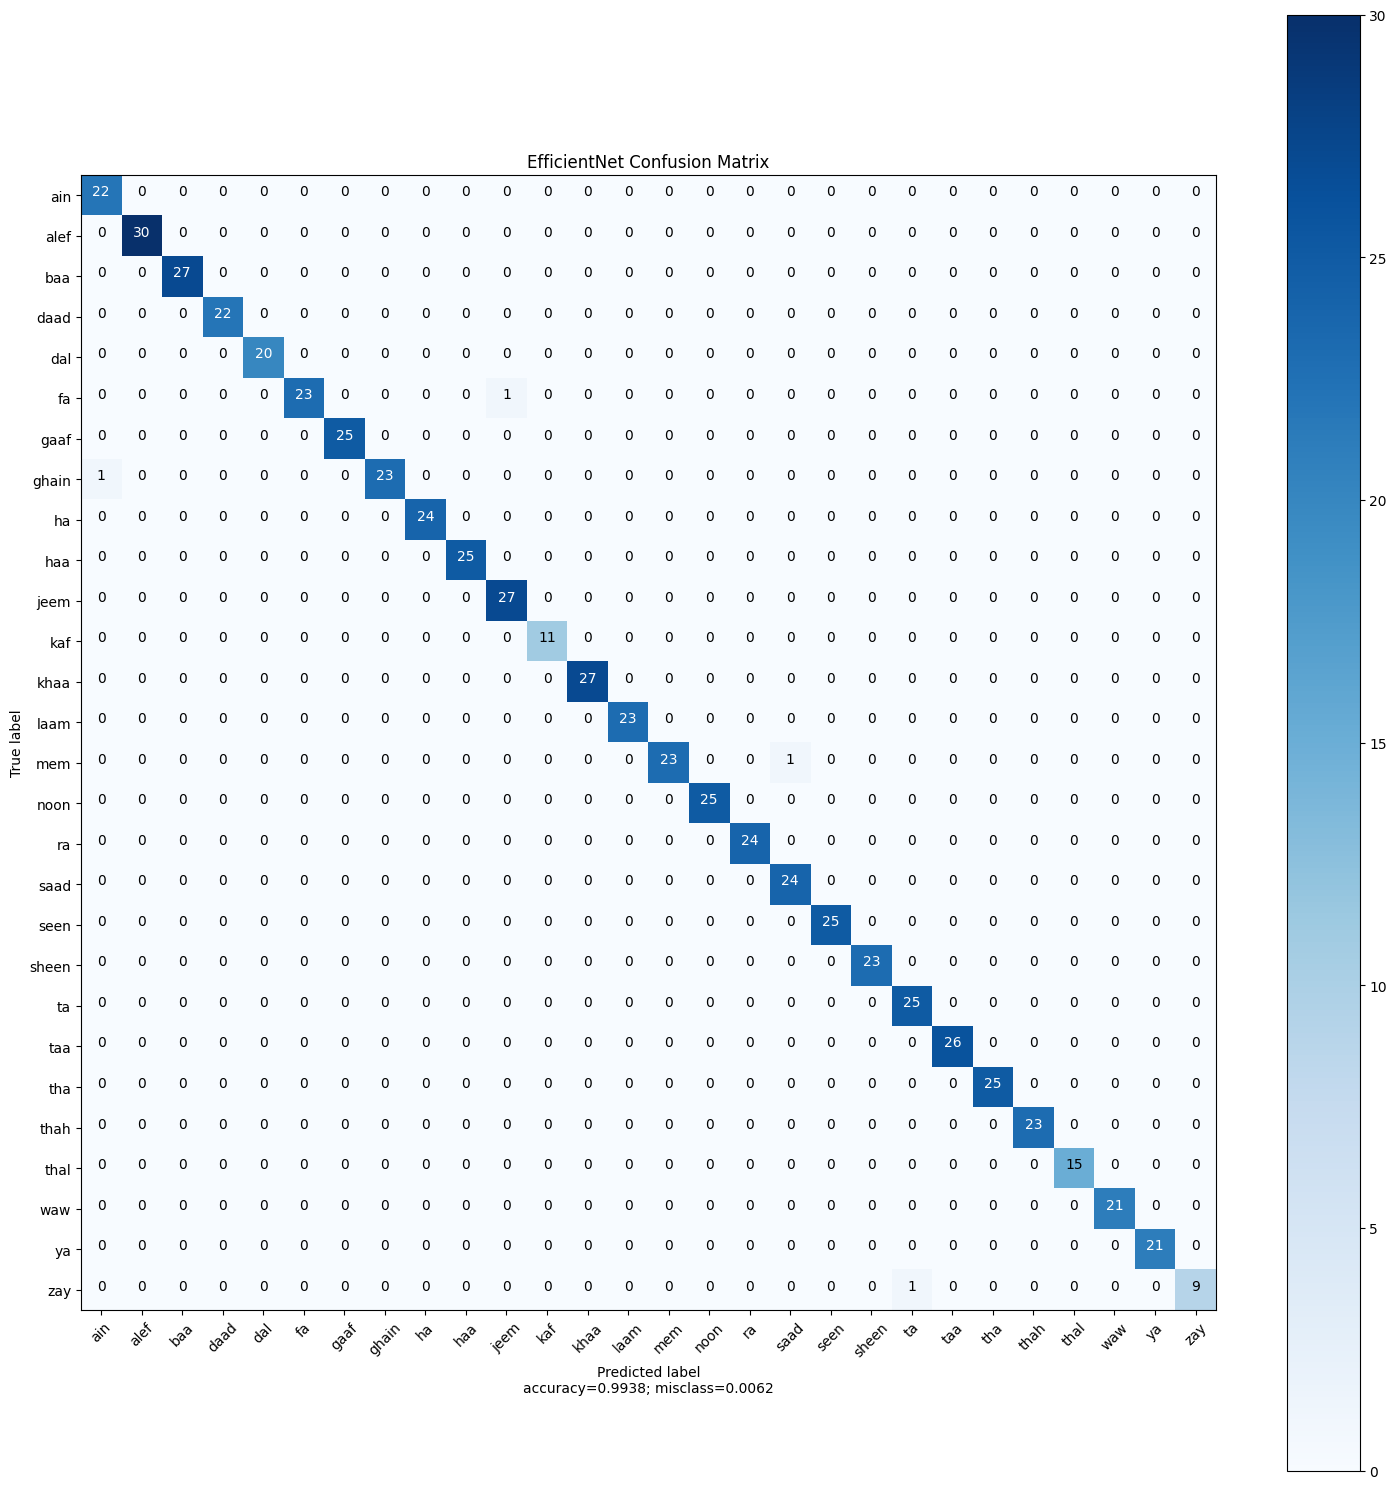

In [20]:
from sklearn.metrics import confusion_matrix

classes =["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

y_true = np.array(test_set.labels)
print("True : ", y_true)

y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print("Predicted : ", y_pred)

conf_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = conf_mat,
                      normalize    = False,
                      target_names = classes,
                      title        = "EfficientNet Confusion Matrix")

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=classes,digits=4))

              precision    recall  f1-score   support

         ain     0.9565    1.0000    0.9778        22
        alef     1.0000    1.0000    1.0000        30
         baa     1.0000    1.0000    1.0000        27
        daad     1.0000    1.0000    1.0000        22
         dal     1.0000    1.0000    1.0000        20
          fa     1.0000    0.9583    0.9787        24
        gaaf     1.0000    1.0000    1.0000        25
       ghain     1.0000    0.9583    0.9787        24
          ha     1.0000    1.0000    1.0000        24
         haa     1.0000    1.0000    1.0000        25
        jeem     0.9643    1.0000    0.9818        27
         kaf     1.0000    1.0000    1.0000        11
        khaa     1.0000    1.0000    1.0000        27
        laam     1.0000    1.0000    1.0000        23
         mem     1.0000    0.9583    0.9787        24
        noon     1.0000    1.0000    1.0000        25
          ra     1.0000    1.0000    1.0000        24
        saad     0.9600    

In [22]:
from sklearn.metrics import confusion_matrix

classes = ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

y_pred = model.predict(val_set)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)
y_true = np.array(val_set.labels)
print(y_true)

21/21 [==============================] - 2s 70ms/step
[10 27  6 27  4 23 17 23 26 23  4  5 11 16  3 22 18 16 21  6  8  2  6  1
 27 26 15 21 12 21  4 22 26  0 12  5 11  3 13 26  5 14  3  7 13  6 21 12
  2 12 14 17 14 10  1 16  8 26 26 24  3  0  4  7 24 17 16 11 12  9 16  9
  1 23  9  6  8 11 18 14 20  8 25 18 16 19  8  4 22 19 22 10  9  4  8  0
 20 18  7  2  5 17 16  7 27  3  1  6 26  5  9 19  1 17 10  2 17 15 27  2
 10  9 13  1  6 17 24  8  9  2 21  5 20 24  4  8  3 23 22 20 15  9  8  0
  8 19 20  6 26 19 25 19 21  6  3 21 22 19  2 17 20 10 16  2 11 12  9  1
  1 20  4 22 25 18  9  6 25 23 16 12 14  2 22 23  6  7  5 14 15 23 26 14
  9  6  1 21  1  1 18 19 16  3 14 22 19  5 14  3  5 13 18 22 13  4 20  2
  6 17 13 10  9  0 26 14  1  2 13 13 12  4 24 18 16 20 27 15 20  7 19 27
  8  0 25  1 15  7 13 19 13 24  2  7 16  4  8  2  3  2  6 13 21 18 17 11
  8  7 24 10 13 26 13  5 12 27  0 14  5  7  3  6 10 18 19  0  5 20  0  9
 21  5 16 19 15 17 12 23 10 13  1 20 22 21 14  7 22 14 14 22  4  1 21 

In [23]:
model.evaluate(test_set)

21/21 [==============================] - 1s 65ms/step - loss: 0.1943 - accuracy: 0.9938


[0.19428402185440063, 0.9937694668769836]

In [24]:
model.evaluate(val_set)

21/21 [==============================] - 2s 92ms/step - loss: 0.1858 - accuracy: 0.9984


[0.18580417335033417, 0.9984399080276489]

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('arsl_effT.tflite', 'wb') as f:
    f.write(tflite_model)

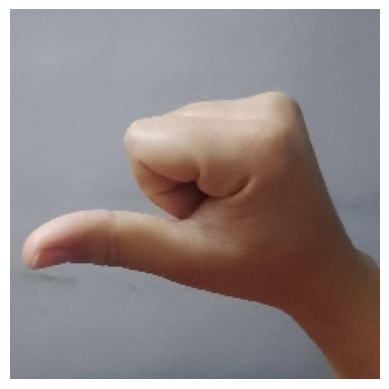

1/1 [==============================] - 2s 2s/step
The predicted class is waw with a confidence of 99.44%.


In [26]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-26-10.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





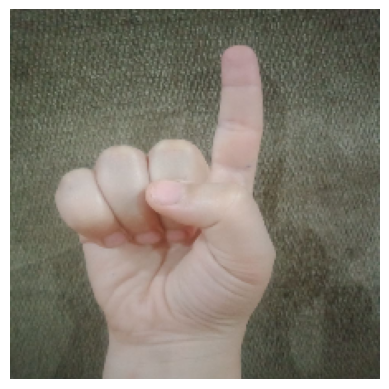

1/1 [==============================] - 0s 32ms/step
The predicted class is baa with a confidence of 99.33%.


In [27]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-14-15.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





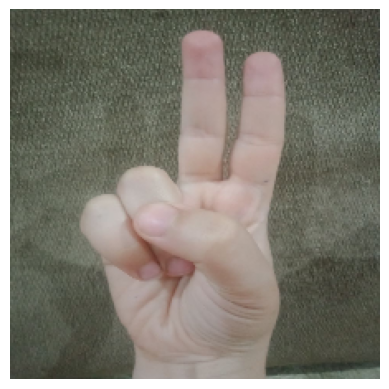

1/1 [==============================] - 0s 29ms/step
The predicted class is ta with a confidence of 99.82%.


In [28]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-14-11.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





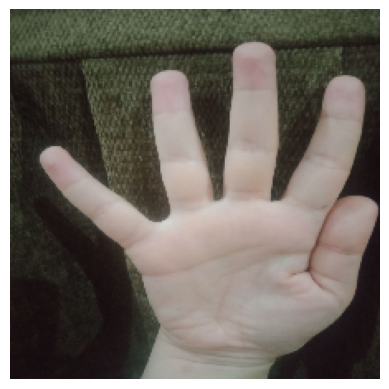

1/1 [==============================] - 0s 30ms/step
The predicted class is sheen with a confidence of 99.58%.


In [29]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-14-06.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





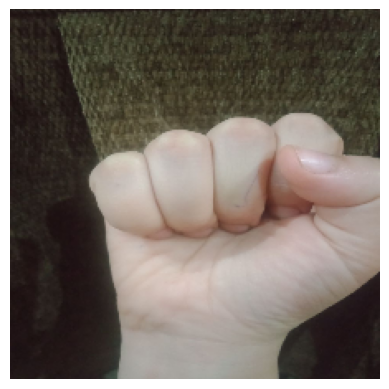

1/1 [==============================] - 0s 67ms/step
The predicted class is saad with a confidence of 99.54%.


In [30]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-13-59.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





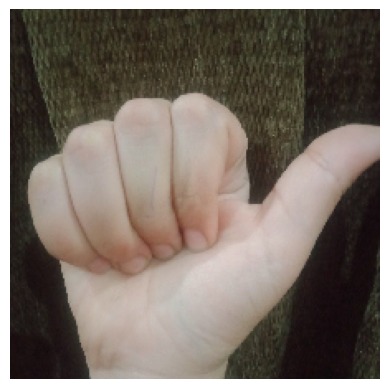

1/1 [==============================] - 0s 30ms/step
The predicted class is daad with a confidence of 99.62%.


In [31]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-13-56.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





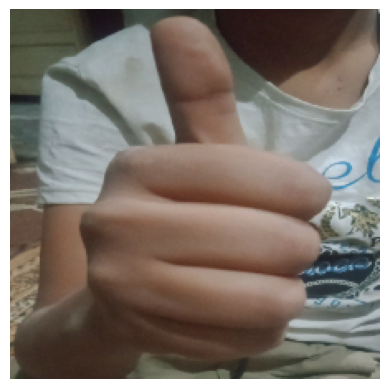

1/1 [==============================] - 0s 31ms/step
The predicted class is alef with a confidence of 99.74%.


In [32]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-05-02.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





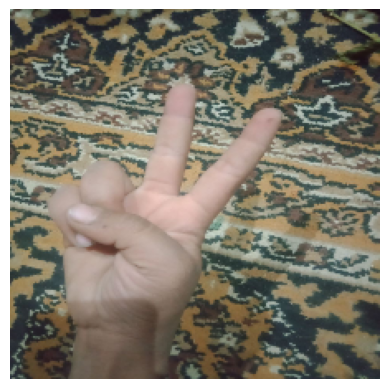

1/1 [==============================] - 0s 31ms/step
The predicted class is ta with a confidence of 90.43%.


In [33]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-04-59.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





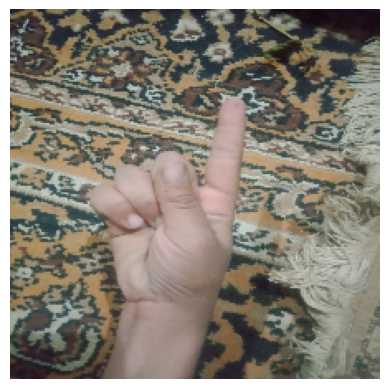

1/1 [==============================] - 0s 31ms/step
The predicted class is baa with a confidence of 64.17%.


In [34]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-04-55.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





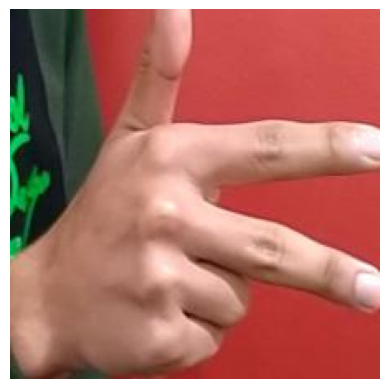

1/1 [==============================] - 0s 30ms/step
The predicted class is ghain with a confidence of 99.81%.


In [36]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/arsl-sign-language/data_for_all/ghain/2023-01-26_20-21-41.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





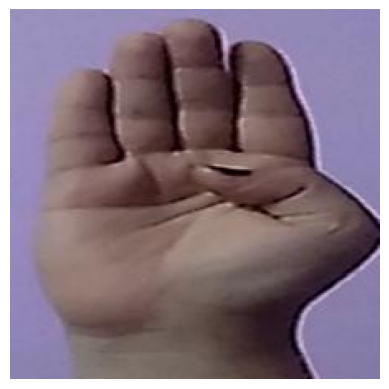

1/1 [==============================] - 0s 30ms/step
The predicted class is kaf with a confidence of 99.07%.


In [37]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/arsl-sign-language/data_for_all/kaf/10.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





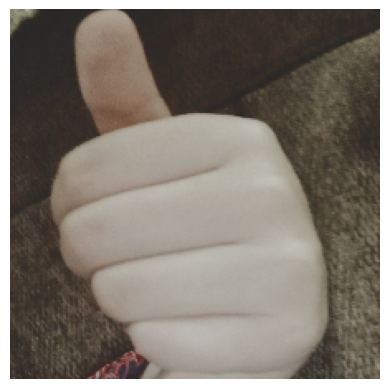

1/1 [==============================] - 0s 30ms/step
The predicted class is alef with a confidence of 99.59%.


In [38]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-14-18.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





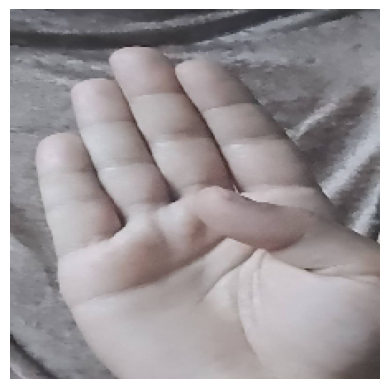

1/1 [==============================] - 0s 28ms/step
The predicted class is kaf with a confidence of 95.05%.


In [39]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-26-07.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))





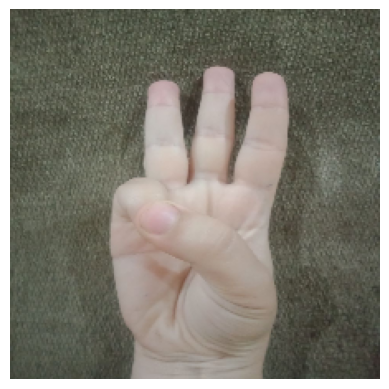

1/1 [==============================] - 0s 31ms/step
The predicted class is tha with a confidence of 93.28%.


In [40]:



# Define image size
img_height, img_width = 224, 224
# Load the image
test_apple_url = "/kaggle/input/datatested/photo_2023-05-08_00-14-09.jpg"
img = tf.keras.utils.load_img(test_apple_url, target_size=(img_height, img_width))

# Convert image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = np.uint8(img_array)


class_names= ["ain","alef","baa","daad","dal","fa","gaaf","ghain","ha","haa","jeem","kaf","khaa","laam","mem","noon","ra","saad","seen","sheen","ta","taa","tha","thah","thal","waw","ya", "zay",]

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
# Make predictions on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Print the prediction results
print("The predicted class is {} with a confidence of {:.2f}%."
      .format(class_names[predicted_class], confidence_score * 100))



